
# Máxima Verossimilhança (Maximum Likelihood Estimation - **MLE**)
**Teoria e prática em Python**

> Este notebook apresenta um guia completo e prático sobre **Máxima Verossimilhança**: onde é utilizada, como construir a função de verossimilhança, como otimizá‑la, como interpretar estimativas e incertezas (erro‑padrão, intervalos de confiança, testes), além de exemplos com **gráficos** e **código Python**.

### Sumário
1. [Introdução: o que é Máxima Verossimilhança e onde é usada](#sec-intro)
2. [Notação, hipóteses e definições](#sec-notacao)
3. [Passo a passo para aplicar MLE em um novo problema](#sec-passos)
4. [Exemplo 1 — Bernoulli: estimando $p$](#sec-bernoulli)
5. [Exemplo 2 — Normal: estimando $\mu$ e $\sigma^2$](#sec-normal)
6. [Exemplo 3 — Poisson: estimando $\lambda$](#sec-poisson)
7. [Exemplo 4 — Regressão Logística via MLE (IRLS / Newton-Raphson)](#sec-logistica)
8. [Inferência com MLE: Informação de Fisher, ICs e Teste da Razão de Verossimilhança](#sec-inferencia)
9. [Regularização (MLE penalizada) e conexão com MAP](#sec-regularizacao)
10. [Boas práticas, armadilhas e dicas](#sec-boas-praticas)
11. [Apêndice: derivadas e detalhes úteis](#sec-apendice)
12. [Referências sugeridas](#sec-ref)



<a id="sec-intro"></a>
## 1. Introdução: o que é Máxima Verossimilhança e onde é usada

A **Máxima Verossimilhança (MLE)** é um princípio geral para **estimar parâmetros** de um modelo estatístico. Dadas observações $x_1,\dots,x_n$ e um modelo paramétrico com densidade (ou massa) $f(x\,|\,\theta)$, escolhemos o parâmetro $\hat{\theta}$ que **torna os dados observados mais prováveis** conforme o modelo.

**Onde é usada:**
- Estatística clássica: estimação de parâmetros em distribuições (Bernoulli, Binomial, Normal, Poisson, Exponencial, etc.).
- **Modelos Lineares Generalizados (GLMs)**: regressão logística (binária), Poisson (contagens), Gamma (positivos), etc.
- **Aprendizado de Máquina**: ao minimizar **log‑loss / cross‑entropy**, estamos **maximizando log‑verossimilhança** (sob suposições adequadas).
- **Inferência**: erros‑padrão assintóticos via **Informação de Fisher**; **testes de razão de verossimilhança**; **intervalos por perfil de verossimilhança**.
- **Modelagem Bayesiana**: MLE é o caso particular do **MAP** com prior uniforme (ou MLE penalizada ≈ MAP com prior não‑uniforme).

Em resumo, MLE fornece uma receita unificada para **estimar**, **quantificar incerteza** e **testar hipóteses** em uma grande variedade de modelos.



<a id="sec-notacao"></a>
## 2. Notação, hipóteses e definições

- Observamos $X_1,\dots,X_n$ (tipicamente assumidos **i.i.d.**).
- O modelo tem parâmetro (possivelmente vetorial) $\theta \in \Theta$ e função densidade/massa $f(x \mid \theta)$.
- **Verossimilhança**: 
  $$
  L(\theta \mid x_1,\dots,x_n) \;=\; \prod_{i=1}^n f(x_i \mid \theta).
  $$
- **Log‑verossimilhança**: 
  $$
  \ell(\theta) \;=\; \log L(\theta) \;=\; \sum_{i=1}^n \log f(x_i \mid \theta).
  $$
- **Estimador de MLE**:
  $$
  \hat{\theta} \;\in\; \arg\max_{\theta \in \Theta} \; \ell(\theta).
  $$

**Propriedades importantes (assintóticas)**:
- **Consistência**: $\hat{\theta} \to \theta_0$ em probabilidade (sob condições regulares).
- **Normalidade Assintótica**: 
  $$
  \sqrt{n}\,(\hat{\theta} - \theta_0) \;\xrightarrow{d}\; \mathcal{N}\!\big(0,\, I(\theta_0)^{-1}\big),
  $$
  onde $I(\theta)$ é a **Informação de Fisher**.
- **Informação de Fisher (esperada)**:
  $$
  I(\theta) \;=\; \mathbb{E}_\theta\!\left[ -\frac{\partial^2}{\partial \theta^2} \,\ell(\theta) \right].
  $$
  A **observada** usa a Hessiana em $\hat{\theta}$:
  $$
  J(\hat{\theta}) \;=\; -\frac{\partial^2}{\partial \theta^2} \,\ell(\theta)\Big|_{\theta=\hat{\theta}}.
  $$

**Erro‑padrão e IC (aprox.)**:
- Em 1D: $\mathrm{Var}(\hat{\theta}) \approx \frac{1}{n\,I(\theta_0)}$; 
  substituindo $\theta_0$ por $\hat{\theta}$: $\widehat{\mathrm{se}}(\hat{\theta}) \approx \sqrt{ \big[ J(\hat{\theta}) \big]^{-1} }$.
- IC (95% aprox.): $\hat{\theta} \pm 1.96 \cdot \widehat{\mathrm{se}}(\hat{\theta})$.

**Observação**: trabalhar com $\ell(\theta)$ é preferível a $L(\theta)$ por estabilidade numérica e por transformar produtos em somas.



<a id="sec-passos"></a>
## 3. Passo a passo para aplicar MLE em um novo problema

1. **Escolha do modelo** $f(x \mid \theta)$ (ex.: Bernoulli($p$), Normal($\mu,\sigma^2$), Poisson($\lambda$) ou GLM).
2. **Escreva a verossimilhança** $L(\theta)$ e **log‑verossimilhança** $\ell(\theta)$.
3. **Derive as condições de ótimo**: derive $\frac{\partial \ell}{\partial \theta}$ e iguale a zero; verifique a concavidade via a Hessiana.
4. **Resolva**: 
   - **Fechado** (analítico), quando existir (ex.: Bernoulli, Poisson, Normal).
   - **Numérico** (gradiente/Newton/IRLS), quando não houver forma fechada (ex.: Regressão Logística).
5. **Incerteza**: calcule **Informação de Fisher observada** $J(\hat{\theta})$, **erro‑padrão** e **ICs**.
6. **Validação**: verifique suposições (i.i.d., forma do modelo), diagnose influências e ajuste.
7. **Relate**: $\hat{\theta}$, se/IC, medidas de ajuste (log‑lik, AIC/BIC), testes (LR/Wald/Score).



<a id="sec-bernoulli"></a>
## 4. Exemplo 1 — Bernoulli: estimando $p$

Suponha $X_i \sim \text{Bernoulli}(p)$ i.i.d., com $x_i \in \{0,1\}$. A verossimilhança é:
$$
L(p) = \prod_{i=1}^n p^{x_i} (1-p)^{1-x_i} = p^k (1-p)^{n-k}, \quad k=\sum x_i.
$$
Log‑verossimilhança:
$$
\ell(p) = k \log p + (n-k) \log (1-p).
$$
Derivando e igualando a zero:
$$
\frac{d\ell}{dp} = \frac{k}{p} - \frac{n-k}{1-p} = 0 
\;\Rightarrow\; \hat{p} = \frac{k}{n}.
$$
A segunda derivada é negativa em $(0,1)$, logo $\hat{p}$ é máximo. A Informação de Fisher (por obs.) é 
$$
I(p) = \frac{1}{p(1-p)}, \quad \Rightarrow \; \mathrm{Var}(\hat{p}) \approx \frac{p(1-p)}{n}.
$$

Abaixo, simulamos dados, traçamos $\ell(p)$ e marcamos o $\hat{p}$ e um IC aproximado.


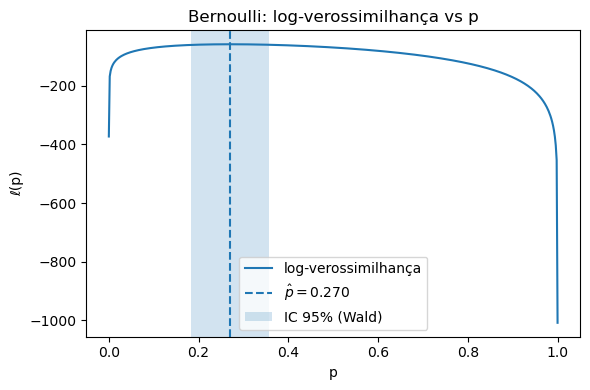

(0.27, (0.18298394630874143, 0.3570160536912586))

In [1]:

import numpy as np
import matplotlib.pyplot as plt

# Simulação
rng = np.random.default_rng(42)
n = 100
p_true = 0.3
x = rng.binomial(1, p_true, size=n)
k = x.sum()
phat = k / n

# Grade de p e log-verossimilhança
pgrid = np.linspace(1e-6, 1-1e-6, 500)
loglik = k*np.log(pgrid) + (n-k)*np.log(1-pgrid)

# IC Wald (aprox.) 95%: phat ± 1.96*sqrt(p(1-p)/n) usando phat
se = np.sqrt(phat*(1-phat)/n)
ic_low = phat - 1.96*se
ic_high = phat + 1.96*se

# Gráfico
plt.figure(figsize=(6,4))
plt.plot(pgrid, loglik, label='log-verossimilhança')
plt.axvline(phat, linestyle='--', label=f'$\hat{{p}}={phat:.3f}$')
plt.axvspan(max(0, ic_low), min(1, ic_high), alpha=0.2, label='IC 95% (Wald)')
plt.xlabel('p')
plt.ylabel('ℓ(p)')
plt.title('Bernoulli: log-verossimilhança vs p')
plt.legend()
plt.tight_layout()
plt.show()

phat, (max(0, ic_low), min(1, ic_high))


* A curva mostra a **log‑verossimilhança** de $p$ para dados Bernoulli:

  $$
  \ell(p)=k\log p+(n-k)\log(1-p).
  $$

  Ela é côncava, tende a $-\infty$ quando $p\to0$ ou $p\to1$, e atinge o **máximo em $p=\hat p$** (linha vertical tracejada).
* A **faixa azul clara** é o **IC de 95% (Wald)** para $p$, calculado ao redor de $\hat p$.

```
(0.27, (0.18298394630874143, 0.3570160536912586))
```

* $\hat p = 0{,}27$.
* **IC de 95% (Wald):** $[0{,}183,\;0{,}357]$.


* O intervalo diz que, **em 95% dos experimentos repetidos do mesmo tipo**, o IC construído desse modo conteria o $p$ verdadeiro.
* Aqui, o $p_{\text{true}}=0{,}3$ **fica dentro** do intervalo $[0{,}183,\;0{,}357]$, o que é consistente com a simulação.



* **“95% de confiança” não é “95% de probabilidade de $p$ estar no seu intervalo”** (para ICs frequencistas).
* Em vez disso: **se você repetir o procedimento infinitas vezes**, cerca de **95% dos intervalos construídos desse jeito** vão conter o $p$ verdadeiro.
* Em uma **única** amostra (a sua), você tem **um** intervalo; ele **ou contém** $p$ **ou não** — o 95% se refere ao **método** ao longo de repetições, não a uma probabilidade sobre este intervalo específico.



**IC por perfil de verossimilhança (LR)**: define-se o conjunto de $p$ que satisfaz
$$
2\big(\ell(\hat{p}) - \ell(p)\big) \le \chi^2_{1,\,0.95} \approx 3.84.
$$
Abaixo, traçamos o perfil e obtemos um IC por LR.


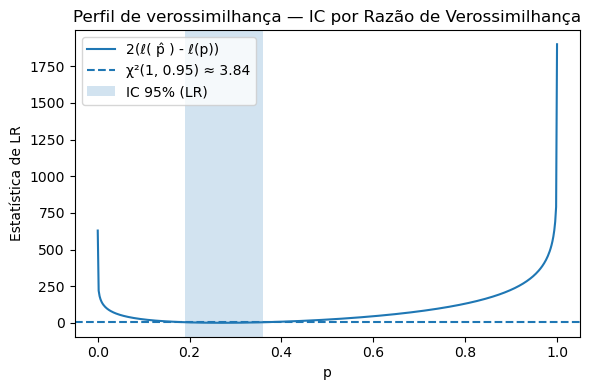

(0.27, (0.19038138076152306, 0.3607217214428857))

In [ ]:
# Perfil de verossimilhança
ell_hat = k*np.log(phat) + (n-k)*np.log(1-phat)
lr_stat = 2*(ell_hat - loglik)

# Limite qui-quadrado 1 gl (95%)
chi2_95 = 3.841458820694124

# Encontrar limites do IC por LR na grade
mask = lr_stat <= chi2_95
p_lr = pgrid[mask]
ic_lr = (p_lr[0], p_lr[-1]) if p_lr.size>0 else (np.nan, np.nan)

plt.figure(figsize=(6,4))
plt.plot(pgrid, lr_stat, label='2(ℓ( p̂ ) - ℓ(p))')
plt.axhline(chi2_95, linestyle='--', label='χ²(1, 0.95) ≈ 3.84')
if p_lr.size>0:
    plt.axvspan(p_lr[0], p_lr[-1], alpha=0.2, label='IC 95% (LR)')
plt.xlabel('p')
plt.ylabel('Estatística de LR')
plt.title('Perfil de verossimilhança — IC por Razão de Verossimilhança')
plt.legend()
plt.tight_layout()
plt.show()

phat, ic_lr


O gráfico mostra a **perda de verossimilhança** ao se afastar de $\hat p$; o **IC de 95% por LR** é o conjunto de $p$ para os quais essa perda **não passa** do nível “esperado por acaso” (corte $\chi^2_1$ a 95%). Para esses dados, isso dá aproximadamente **$p \in [0{,}190,\;0{,}361]$**.



<a id="sec-normal"></a>
## 5. Exemplo 2 — Normal: estimando $\mu$ e $\sigma^2$

Se $X_i \sim \mathcal{N}(\mu, \sigma^2)$ i.i.d., a log‑verossimilhança é
$$
\ell(\mu,\sigma^2) = -\frac{n}{2}\log(2\pi) - \frac{n}{2}\log \sigma^2 - \frac{1}{2\sigma^2}\sum_{i=1}^n (x_i - \mu)^2.
$$
As MLEs são
$$
\hat{\mu} = \bar{x}, \qquad 
\hat{\sigma}^2 = \frac{1}{n}\sum_{i=1}^n (x_i-\bar{x})^2
$$
(nota: o estimador **não‑viesado** usa denominador $n-1$, mas a MLE usa $n$).

Abaixo, simulamos dados e ilustramos $\ell(\mu \mid \sigma^2\ \text{fixo})$ e 
$\ell(\sigma^2 \mid \mu\ \text{fixo})$.


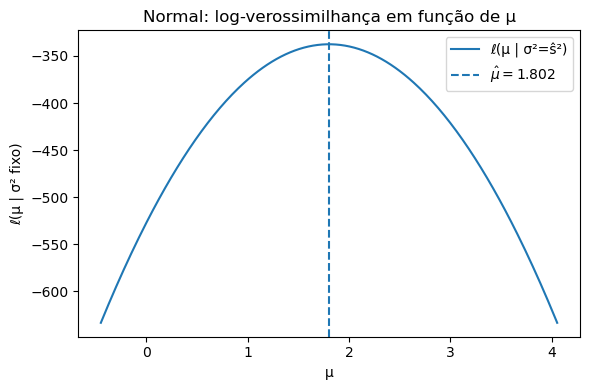

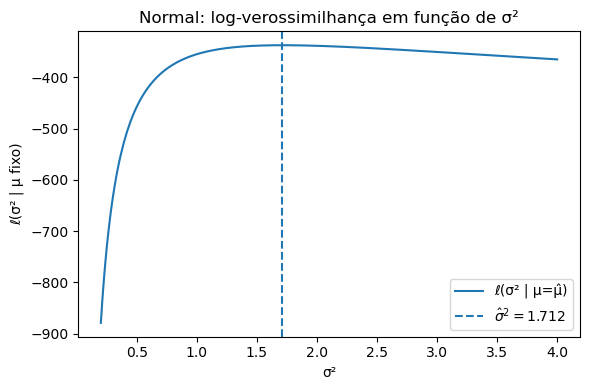

(1.802057060921203, 1.71208236737165)

In [ ]:
rng = np.random.default_rng(7)
n = 200
mu_true = 2.0
sigma_true = 1.5
x = rng.normal(mu_true, sigma_true, size=n)

muhat = x.mean()
s2hat = ((x - muhat)**2).mean()

# Log-verossimilhança como função de mu com sigma^2 fixo em s2hat
mu_grid = np.linspace(muhat - 1.5*sigma_true, muhat + 1.5*sigma_true, 300)
ell_mu = -(n/2)*np.log(2*np.pi) - (n/2)*np.log(s2hat) - (1/(2*s2hat))*((x[:,None]-mu_grid[None,:])**2).sum(axis=0)

plt.figure(figsize=(6,4))
plt.plot(mu_grid, ell_mu, label='ℓ(μ | σ²=ŝ²)')
plt.axvline(muhat, linestyle='--', label=f'$\hat{{\mu}}={muhat:.3f}$')
plt.xlabel('μ')
plt.ylabel('ℓ(μ | σ² fixo)')
plt.title('Normal: log-verossimilhança em função de μ')
plt.legend()
plt.tight_layout()
plt.show()

# Log-verossimilhança como função de sigma^2 com mu fixo em muhat
s2_grid = np.linspace(0.2, 4.0, 300)
ell_s2 = -(n/2)*np.log(2*np.pi) - (n/2)*np.log(s2_grid) - (1/(2*s2_grid))*((x - muhat)**2).sum()

plt.figure(figsize=(6,4))
plt.plot(s2_grid, ell_s2, label='ℓ(σ² | μ=μ̂)')
plt.axvline(s2hat, linestyle='--', label=f'$\hat{{\sigma}}^2={s2hat:.3f}$')
plt.xlabel('σ²')
plt.ylabel('ℓ(σ² | μ fixo)')
plt.title('Normal: log-verossimilhança em função de σ²')
plt.legend()
plt.tight_layout()
plt.show()

muhat, s2hat



<a id="sec-poisson"></a>
## 6. Exemplo 3 — Poisson: estimando $\lambda$

Se $X_i \sim \text{Poisson}(\lambda)$ i.i.d.,
$$
\ell(\lambda) = \sum_i \{ x_i \log \lambda - \lambda - \log(x_i!) \}.
$$
Derivando: $\frac{d\ell}{d\lambda} = \sum_i \frac{x_i}{\lambda} - n = \frac{n\bar{x}}{\lambda} - n$; logo $\hat{\lambda} = \bar{x}$.

Abaixo, simulamos dados e traçamos $\ell(\lambda)$, marcando a MLE.


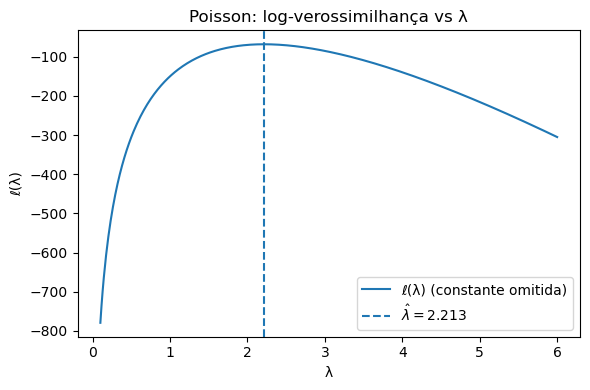

2.2133333333333334

In [4]:
rng = np.random.default_rng(123)
n = 150
lam_true = 2.2
x = rng.poisson(lam_true, size=n)
lamhat = x.mean()

# Grade de lambda e log-verossimilhança (ignorando a parte -log(x!) por ser constante em λ)
lam_grid = np.linspace(0.1, 6.0, 400)
ell = (x[:,None]*np.log(lam_grid[None,:]) - lam_grid[None,:]).sum(axis=0)

plt.figure(figsize=(6,4))
plt.plot(lam_grid, ell, label='ℓ(λ) (constante omitida)')
plt.axvline(lamhat, linestyle='--', label=f'$\hat{{\lambda}}={lamhat:.3f}$')
plt.xlabel('λ')
plt.ylabel('ℓ(λ)')
plt.title('Poisson: log-verossimilhança vs λ')
plt.legend()
plt.tight_layout()
plt.show()

lamhat



<a id="sec-logistica"></a>
## 7. Exemplo 4 — Regressão Logística via MLE (IRLS / Newton-Raphson)

Para $Y_i \in \{0,1\}$ com preditores $\mathbf{x}_i \in \mathbb{R}^p$, o modelo é
$$
\Pr(Y_i=1 \mid \mathbf{x}_i) = \sigma(\eta_i), \quad \eta_i = \mathbf{x}_i^\top \boldsymbol{\beta}, \quad \sigma(t)=\frac{1}{1+e^{-t}}.
$$
A **log‑verossimilhança** é
$$
\ell(\boldsymbol{\beta}) = \sum_{i=1}^n \left\{ y_i\,\mathbf{x}_i^\top\boldsymbol{\beta} - \log\!\big(1 + e^{\mathbf{x}_i^\top\boldsymbol{\beta}}\big) \right\}.
$$
**Gradiente** e **Hessiana**:
$$
\nabla \ell(\boldsymbol{\beta}) = X^\top ( \mathbf{y} - \mathbf{p} ), 
\qquad 
H(\boldsymbol{\beta}) = -X^\top W X,
$$
onde $p_i=\sigma(\eta_i)$ e $W=\mathrm{diag}(p_i(1-p_i))$.  
O método **Newton‑Raphson / IRLS** atualiza:
$$
\boldsymbol{\beta}^{(t+1)} = \boldsymbol{\beta}^{(t)} - H^{-1} \nabla \ell.
$$

Abaixo implementamos IRLS (com intercepto e opção de **Ridge** $\lambda \lVert\beta\rVert_2^2/2$ para casos quase separáveis). Também visualizamos a fronteira de decisão.


In [5]:
def sigmoid(z):
    # Estável numericamente
    out = np.empty_like(z, dtype=float)
    pos = z >= 0
    neg = ~pos
    out[pos] = 1.0/(1.0 + np.exp(-z[pos]))
    ez = np.exp(z[neg])
    out[neg] = ez/(1.0 + ez)
    return out

def logistic_irls(X, y, lam=0.0, max_iter=100, tol=1e-6, fit_intercept=True, penalize_intercept=False):
    n, p_no_intercept = X.shape
    if fit_intercept:
        X_ = np.c_[np.ones(n), X]
    else:
        X_ = X
    p = X_.shape[1]
    beta = np.zeros(p)
    I = np.eye(p)
    if fit_intercept and not penalize_intercept:
        I[0,0] = 0.0  # não penalizar intercepto

    for it in range(max_iter):
        eta = X_.dot(beta)
        p_hat = sigmoid(eta)
        W = p_hat*(1-p_hat)
        # Evitar zeros exatos
        W = np.clip(W, 1e-12, None)
        # Gradiente e Hessiana (observada) com penalização L2
        grad = X_.T.dot(y - p_hat) - lam * (I.dot(beta))
        H = -(X_.T * W).dot(X_) - lam * I

        # Resolver passo de Newton: H * step = grad
        try:
            step = np.linalg.solve(H, grad)
        except np.linalg.LinAlgError:
            # Regularização extra se mal-condicionado
            H_reg = H - 1e-6*np.eye(p)
            step = np.linalg.lstsq(H_reg, grad, rcond=None)[0]

        beta_new = beta - step
        if np.linalg.norm(step) < tol:
            beta = beta_new
            break
        beta = beta_new

    # Erros-padrão usando informação observada no ponto final
    eta = X_.dot(beta)
    p_hat = sigmoid(eta)
    W = np.clip(p_hat*(1-p_hat), 1e-12, None)
    H_final = -(X_.T * W).dot(X_) - lam * I
    cov = np.linalg.pinv(-H_final)
    se = np.sqrt(np.diag(cov))
    return beta, se, cov, (X_, y)

# Gerar dados simulados 2D
rng = np.random.default_rng(0)
n = 300
X = rng.normal(size=(n,2))
beta_true = np.array([-0.5, 2.0, -1.0])  # intercepto, beta1, beta2
eta = beta_true[0] + X.dot(beta_true[1:])
p_true = 1/(1+np.exp(-eta))
y = rng.binomial(1, p_true)

beta_hat, se_hat, cov_hat, (X_design, y_) = logistic_irls(X, y, lam=0.0, max_iter=100, tol=1e-8)
beta_hat, se_hat


(array([-0.47178371,  1.94433057, -1.28153391]),
 array([0.1610126 , 0.23499104, 0.20579361]))

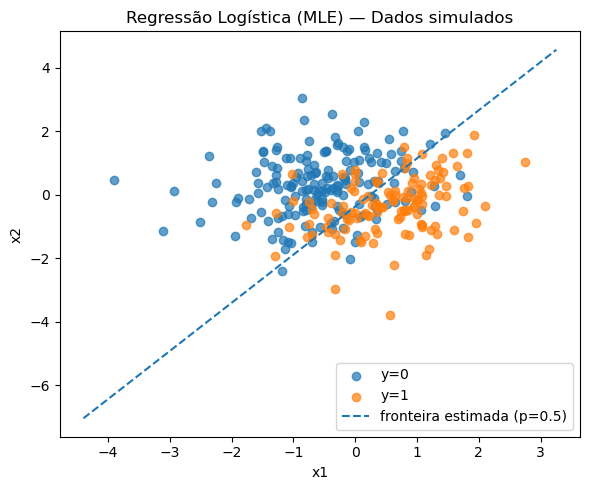

In [6]:
# Separamos classes para plotar
X0 = X[y==0]
X1 = X[y==1]

plt.figure(figsize=(6,5))
plt.scatter(X0[:,0], X0[:,1], label='y=0', alpha=0.7)
plt.scatter(X1[:,0], X1[:,1], label='y=1', alpha=0.7)

# Fronteira p=0.5 -> beta0 + beta1 x1 + beta2 x2 = 0
b0, b1, b2 = beta_hat
x1_line = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200)
# evitar divisão por zero
if abs(b2) < 1e-12:
    pass  # não plota a linha se b2 ~ 0
else:
    x2_line = -(b0 + b1*x1_line)/b2
    plt.plot(x1_line, x2_line, linestyle='--', label='fronteira estimada (p=0.5)')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Regressão Logística (MLE) — Dados simulados')
plt.legend()
plt.tight_layout()
plt.show()



**Notas importantes:**
- Se os dados são **linearmente separáveis**, a MLE **pode não existir** (coeficientes divergem). Uma solução prática é usar **regularização L2** (Ridge), equivalente a MLE **penalizada** (ver Seção 9).
- A matriz $X^\top W X$ fornece a **informação observada**; o inverso dá a matriz de covariância assintótica dos coeficientes (erros‑padrão).



<a id="sec-inferencia"></a>
## 8. Inferência com MLE: Informação de Fisher, ICs e Teste da Razão de Verossimilhança

### 8.1 Informação de Fisher e erros‑padrão
- **Observada**: $J(\hat{\theta}) = -\frac{\partial^2}{\partial\theta^2}\ell(\theta)\big|_{\hat{\theta}}$.
- **Variância assintótica**: $\mathrm{Var}(\hat{\theta}) \approx J(\hat{\theta})^{-1}$.
- Em GLMs, $J(\hat{\beta}) = X^\top W X$ (com sinal), onde $W=\mathrm{diag}(p_i(1-p_i))$ na logística.

### 8.2 Teste da Razão de Verossimilhança (LR)
Para testar $H_0:\theta=\theta_0$ vs $H_1:\theta\neq\theta_0$:
$$
\Lambda = 2\big[\ell(\hat{\theta}) - \ell(\theta_0)\big] \;\xrightarrow{d}\; \chi^2_{q},
$$
onde $q$ é a diferença de dimensão entre modelos. Valores altos de $\Lambda$ **rejeitam** $H_0$.

### 8.3 Exemplo: Bernoulli, teste $H_0: p=p_0$
$$
\Lambda = 2\left[ k\log\frac{\hat{p}}{p_0} + (n-k)\log\frac{1-\hat{p}}{1-p_0} \right].
$$
Abaixo calculamos $\Lambda$ e o *p‑value* aproximado ($\chi^2_1$).


In [7]:
# Reutilizando os dados Bernoulli anteriores (k, n, phat)
p0 = 0.5
# Manter dentro de (0,1)
eps = 1e-12
ph = np.clip(phat, eps, 1-eps)
p0c = np.clip(p0, eps, 1-eps)
LR = 2*(k*np.log(ph/p0c) + (n-k)*np.log((1-ph)/(1-p0c)))

# p-valor com qui-quadrado 1 gl
pval = np.nan
try:
    from scipy.stats import chi2
    pval = 1 - chi2.cdf(LR, df=1)
except Exception:
    # fallback usando mpmath (CDF do qui-quadrado via função gama incompleta)
    try:
        import mpmath as mp
        kdf = 1
        pval = 1 - mp.gammainc(kdf/2, 0, LR/2)/mp.gamma(kdf/2)
        pval = float(pval)
    except Exception:
        pval = float('nan')

LR, pval


(173.35224237436768, 0.0)


<a id="sec-regularizacao"></a>
## 9. Regularização (MLE penalizada) e conexão com MAP

Em alguns problemas, a verossimilhança é **plana** ou **não atinge máximo finito** (ex.: separação perfeita na logística).  
Adicionar uma **penalização** é útil:
$$
\ell_\text{pen}(\beta) = \ell(\beta) - \frac{\lambda}{2}\lVert \beta \rVert_2^2 \quad (\text{Ridge}).
$$
Isto equivale ao estimador **MAP** com prior $\beta \sim \mathcal{N}(0, \tau^2 I)$, com $\lambda = 1/\tau^2$.  
A penalização **encolhe** coeficientes e melhora a estabilidade numérica.

Abaixo, usamos $\lambda>0$ no IRLS.


In [8]:

# Rodando logística com Ridge para comparação
beta_ridge, se_ridge, _, _ = logistic_irls(X, y, lam=2.0, max_iter=200, tol=1e-8)

beta_hat, beta_ridge, se_ridge


(array([-0.47178371,  1.94433057, -1.28153391]),
 array([-0.43748949,  1.72568606, -1.12383684]),
 array([0.15348806, 0.20356666, 0.18255841]))


<a id="sec-boas-praticas"></a>
## 10. Boas práticas, armadilhas e dicas

- **Escalonamento de variáveis** ajuda a otimização (principalmente em modelos com muitos preditores).
- **Identificabilidade**: garanta que parâmetros são identificáveis (evite colinearidade perfeita).
- **Fronteiras do parâmetro** (ex.: $p\in[0,1]$): respeite restrições; use transformações (logit, log) quando útil.
- **Estabilidade numérica**: use log‑verossimilhança, *log‑sum‑exp*, *sigmoid* estável.
- **Tamanho amostral**: resultados assintóticos podem falhar em amostras pequenas; considere *bootstrap*.
- **Diagnóstico**: verifique resíduos, pontos influentes, *goodness‑of‑fit* e preditivo.
- **Comparação de modelos**: use **LR**, **AIC/BIC**, validação cruzada (quando predição for o objetivo).



<a id="sec-apendice"></a>
## 11. Apêndice: derivadas e detalhes úteis

- **Bernoulli**: 
  $$
  \ell(p) = k\log p + (n-k)\log(1-p),\ 
  \frac{d\ell}{dp} = \frac{k}{p} - \frac{n-k}{1-p},\ 
  \frac{d^2\ell}{dp^2} = -\frac{k}{p^2} - \frac{n-k}{(1-p)^2}.
  $$

- **Normal**: 
  $$
  \frac{\partial \ell}{\partial \mu} = \frac{1}{\sigma^2}\sum (x_i-\mu),\qquad 
  \frac{\partial \ell}{\partial \sigma^2} = -\frac{n}{2\sigma^2} + \frac{1}{2(\sigma^2)^2}\sum (x_i-\mu)^2.
  $$

- **Poisson**: 
  $$
  \frac{d\ell}{d\lambda} = \sum \frac{x_i}{\lambda} - n,\qquad 
  \frac{d^2\ell}{d\lambda^2} = -\sum \frac{x_i}{\lambda^2}.
  $$

- **Logística (vetorial)**: 
  $$
  \nabla \ell(\beta) = X^\top(y-p),\quad 
  H(\beta) = -X^\top W X,\quad p=\sigma(X\beta).
  $$
